# MacOS/M1 Compatibility Setup
This cell provides instructions and code to ensure Geneformer and dependencies run on MacOS/M1 (Apple Silicon).
- All paths have been updated to use the local project structure.
- Colab/`/content/` commands have been removed.
- Geneformer will be patched to use CPU or MPS (Apple Silicon) if available.
- Install dependencies using your local environment (see `requirements.txt` and `environment.yml` in `scripts/sjogrens/`).

In [1]:
# Patch Geneformer and PyTorch for MacOS/M1 (Apple Silicon) compatibility
import torch
import os
def get_device():
    return "cpu"
device = get_device()
print(f"Using device: {device}")
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# If using Geneformer, ensure model and tensors are moved to the correct device
# Example: model.to(device), tensor.to(device)
# If Geneformer code uses 'cuda' by default, patch it to use 'device' variable above

Using device: cpu


In [2]:
# Set project directory
PDIR = "/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade"

In [3]:
# Force Python to use the local Geneformer source (with MPS/CPU support)
import sys
sys.path.insert(0, f"{PDIR}/content/Geneformer")

In [4]:
# Uninstall pip-installed geneformer to force use of local patched version
!pip uninstall -y geneformer

# Download data from cellxgene census

> Only need to run this section once for initial data downloading. Skip this section on all proceeding runs due to import incompatibility errors

In [ ]:
# Install cellxgene-census if not already installed (run in terminal or notebook)
# !pip install -U cellxgene-census  # Uncomment if needed

In [ ]:
import cellxgene_census

census = cellxgene_census.open_soma(census_version="latest")
census["census_info"]["summary"].read().concat().to_pandas()

# Get all dataset citations from census
datasets = census["census_info"]["datasets"].read().concat().to_pandas()

## Fetch AnnData from Census

In [ ]:
import os
os.makedirs(f"{PDIR}/content/raw-data", exist_ok=True)

In [ ]:
# Fetch an AnnData object
dataset_id = "df1edb87-e512-43ae-b5f4-cb179cfc2bb4" # https://datasets.cellxgene.cziscience.com/31380664-ba9c-49d1-9961-b2bf4f7131a2.h5ad
cellxgene_census.download_source_h5ad(dataset_id, to_path=f"{PDIR}/content/raw-data/cxg_sjogrens.h5ad", progress_bar=True)
census.close()

## Fetch citation for dataset

In [ ]:
# Get a citation string for the slice
datasets[datasets["dataset_id"] == dataset_id].iloc[0]

# Prepare data for Geneformer

#### The input data for Geneformer is single-cell RNA-seq (scRNAseq) data composed of a raw count matrix stored in .loom or .h5ad format. If data is in another format (e.g., .csv, .mtx), it should be converted to .loom or .h5ad using Scanpy or Anndata tools.

#### No normalization, transformation, or feature selection should be performed. Removal of cells per standard quality controls (e.g., removal of empty droplets, damaged cells, doublets, etc.) is recommended.

In [5]:
import scanpy as sc
adata = sc.read_h5ad(f"{PDIR}/content/raw-data/cxg_sjogrens.h5ad")

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packag

In [6]:
adata

AnnData object with n_obs × n_vars = 94227 × 31969
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'total_counts_hb', 'pct_counts_hb', 'Sample', 'batch', 'leiden', 'leiden_before', 'Immune_All_High.pkl', 'Immune_All_AddPIP.pkl', 'Immune_All_Low.pkl', 'Immune_All_PIP.pkl', 'Cells_Intestinal_Tract.pkl', 'Cells_Lung_Airway.pkl', 'Developing_Mouse_Brain.pkl', 'Nuclei_Lung_Airway.pkl', 'Pan_Fetal_Human.pkl', 'Focus Score', 'SSA', 'ANA', 'Annotation', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'medical_background', 'suspension_type', 'sex_ontology_term_id', 'donor_id', 'is_primary_data', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'mt', 'rp', 'hb', 'highly

In [7]:
adata.obs

,n_genes,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_rp,pct_counts_rp,total_counts_hb,pct_counts_hb,...,is_primary_data,tissue_type,cell_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
TCAATTCTCTTGGTCC-1-1,7669,238340.0,7669,238340.0,73.0,0.030629,27903.0,11.707225,0.0,0.000000,...,True,tissue,acinar cell of salivary gland,10x 3' v3,normal,female,labial gland,African American,35-year-old stage,p*esn;7zns
CAGATTGTCACGAACT-1-1,7949,236529.0,7949,236529.0,36.0,0.015220,38970.0,16.475780,0.0,0.000000,...,True,tissue,acinar cell of salivary gland,10x 3' v3,normal,female,labial gland,African American,35-year-old stage,B~?5gyw$k8
TGATCTTTCTTGGTCC-1-1,6614,221995.0,6614,221995.0,0.0,0.000000,39420.0,17.757156,0.0,0.000000,...,True,tissue,acinar cell of salivary gland,10x 3' v3,normal,female,labial gland,African American,35-year-old stage,0kYbSzkgca
CCGTTCAAGACATATG-1-1,7965,221002.0,7965,221002.0,1875.0,0.848409,27994.0,12.666854,1.0,0.000452,...,True,tissue,myoepithelial cell,10x 3' v3,normal,female,labial gland,African American,35-year-old stage,6CN0&gx15+
GGGTTATCATCGAGCC-1-1,7341,219529.0,7341,219529.0,0.0,0.000000,38020.0,17.318897,0.0,0.000000,...,True,tissue,acinar cell of salivary gland,10x 3' v3,normal,female,labial gland,African American,35-year-old stage,<p*%{_>GJr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACTTGTGTCTACAAC-1-38,154,218.0,154,218.0,2.0,0.917431,28.0,12.844036,1.0,0.458716,...,True,tissue,acinar cell of salivary gland,10x 3' v3,Sjogren syndrome,female,labial gland,European American,50-year-old stage,X95IfDnuo>
ATGGTTGTCGGAGATG-1-38,74,129.0,74,129.0,2.0,1.550388,3.0,2.325581,0.0,0.000000,...,True,tissue,"CD8-positive, alpha-beta cytotoxic T cell",10x 3' v3,Sjogren syndrome,female,labial gland,European American,50-year-old stage,a{*oSt0NK#
TTCCGGTTCGCGGACT-1-38,164,188.0,164,188.0,2.0,1.063830,11.0,5.851064,0.0,0.000000,...,True,tissue,fibroblast,10x 3' v3,Sjogren syndrome,female,labial gland,European American,50-year-old stage,918pjw$xmw
AACCTTTGTTCATCTT-1-38,100,124.0,100,124.0,0.0,0.000000,3.0,2.419355,0.0,0.000000,...,True,tissue,"CD8-positive, alpha-beta cytotoxic T cell",10x 3' v3,Sjogren syndrome,female,labial gland,European American,50-year-old stage,S3S|}CpDJN


In [8]:
adata.var

,mt,rp,hb,highly_variable,means,dispersions,dispersions_norm,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,feature_type
ENSG00000243485,False,False,False,False,5.936808e-06,-0.580874,-3.119813,False,MIR1302-2HG,NCBITaxon:9606,gene,517,lncRNA
ENSG00000237613,False,False,False,False,1.000000e-12,NaN,0.000000,False,FAM138A,NCBITaxon:9606,gene,1015,lncRNA
ENSG00000186092,False,False,False,False,1.000000e-12,NaN,0.000000,False,OR4F5,NCBITaxon:9606,gene,2618,protein_coding
ENSG00000239945,False,False,False,False,4.593860e-05,0.493031,-1.894246,False,ENSG00000239945,NCBITaxon:9606,gene,1319,lncRNA
ENSG00000239906,False,False,False,False,1.000000e-12,NaN,0.000000,False,ENSG00000239906,NCBITaxon:9606,gene,323,lncRNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000277856,False,False,False,True,3.515507e-02,6.892033,5.408454,False,ENSG00000277856,NCBITaxon:9606,gene,294,protein_coding
ENSG00000275063,False,False,False,True,2.517536e-02,3.115924,1.099064,False,ENSG00000275063,NCBITaxon:9606,gene,351,protein_coding
ENSG00000271254,False,False,False,True,3.006966e-02,2.679734,0.601274,False,ENSG00000271254,NCBITaxon:9606,gene,2922,protein_coding
ENSG00000277475,False,False,False,False,1.000000e-12,NaN,0.000000,False,ENSG00000277475,NCBITaxon:9606,gene,831,protein_coding


#### The genes must be labeled as Ensembl IDs. If your dataset includes only gene symbols instead, you can use external tools like Ensembl Biomart or MyGeneInfo to convert them.

In [9]:
# Duplicate index to a new .var column -> "ensembl_id"
adata.var["ensembl_id"] = adata.var.index

#### The data may contain additional feature labels that one would like to retain in the tokenized dataset, for example to use as labels for embeddings or fine-tuning, or to confirm balancing of attributes across data splits.

In [10]:
# Sjogren syndrome
# normal (control)
set(adata.obs["disease"])

{'Sjogren syndrome', 'normal'}

In [11]:
# cell type annotations from original authors
set(adata.obs["cell_type"])

{'B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta cytotoxic T cell',
 'CD8-positive, alpha-beta regulatory T cell',
 'IgA plasma cell',
 'IgG plasma cell',
 'acinar cell of salivary gland',
 'alternatively activated macrophage',
 'dendritic cell',
 'duct epithelial cell',
 'effector CD8-positive, alpha-beta T cell',
 'endothelial cell',
 'fibroblast',
 'inflammatory macrophage',
 'ionocyte',
 'mature NK T cell',
 'myoepithelial cell',
 'pro-T cell',
 'smooth muscle cell'}

In [12]:
# collapse macrophage and plasma cell subtypes into broader categories
rename_dict = {
    "alternatively activated macrophage": "Macrophage",
    "inflammatory macrophage": "Macrophage",
    "IgA plasma cell": "Plasma cell",
    "IgG plasma cell": "Plasma cell"
}

# create unified cell-type annotation
adata.obs["cell_type_union"] = [
    rename_dict.get(ct, ct) for ct in adata.obs["cell_type"]
]

# sanity check
set(adata.obs["cell_type_union"])

{'B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta cytotoxic T cell',
 'CD8-positive, alpha-beta regulatory T cell',
 'Macrophage',
 'Plasma cell',
 'acinar cell of salivary gland',
 'dendritic cell',
 'duct epithelial cell',
 'effector CD8-positive, alpha-beta T cell',
 'endothelial cell',
 'fibroblast',
 'ionocyte',
 'mature NK T cell',
 'myoepithelial cell',
 'pro-T cell',
 'smooth muscle cell'}

In [13]:
# reformat developmental stage / age attribute
set(adata.obs["development_stage"])

# keep only first two characters (e.g., "Adult" -> "Ad")
adata.obs["development_stage"] = [
    ds[:2] for ds in adata.obs["development_stage"]
]

# sanity check
set(adata.obs["development_stage"])

{'35',
 '38',
 '39',
 '40',
 '43',
 '45',
 '47',
 '48',
 '50',
 '51',
 '53',
 '54',
 '55',
 '56',
 '58',
 '59',
 '61',
 '65',
 '75'}

#### Optionally, one may provide a binary "filter_pass" attribute that indicates whether to include (1) or exclude (0) the cell from tokenization.

In [14]:
# select cell types relevant to complement production, regulation, and signaling
included_cell_types = [
    # myeloid
    "Macrophage",
    "Dendritic cell",

    # adaptive immune
    "B cell",
    "Plasma cell",
    "CD4-positive, alpha-beta T cell",
    "CD8-positive, alpha-beta cytotoxic T cell",
    "mature NK T cell",

    # stromal / vascular
    "fibroblast",
    "endothelial cell",
    "smooth muscle cell"
]

# create filter_pass flag for Geneformer tokenization
adata.obs["filter_pass"] = [
    1 if ct in included_cell_types else 0
    for ct in adata.obs["cell_type_union"]
]

# sanity check
adata.obs["filter_pass"].value_counts()

filter_pass
0    57375
1    36852
Name: count, dtype: int64

In [15]:
import os
os.makedirs(f"{PDIR}/content/input-data", exist_ok=True)

In [16]:
# Save prepared AnnData object for Geneformer tokenization
adata.write_h5ad(f"{PDIR}/content/input-data/cxg_sjogrens_prepared.h5ad")

In [17]:
custom_attrs = {
  "cell_type_union": "cell-type", # Here, this attribute is renamed
  "disease": "disease",
  "donor_id": "individual", # Patient ID, later used for data splits
  "development_stage": "age",
  "sex": "sex"
}

# Download Geneformer (local installation)

In [ ]:
!git lfs install
!git clone https://huggingface.co/ctheodoris/Geneformer "{PDIR}/content/Geneformer"

In [ ]:
%cd "{PDIR}/content/Geneformer"

In [ ]:
!pip install .

In [ ]:
# Install compatible versions for Geneformer and dependencies
import sys
!{sys.executable} -m pip install fsspec==2025.12.0 s3fs==2025.12.0 gcsfs==2025.12.0

# Tokenize data using Geneformer

#### The single-cell transcriptomic input data is then tokenized into rank value encodings that represent a nonparametric view of the transcriptome that prioritizes genes that uniquely distinguish cell states.

#### For detailed documentation of the various arguments, please see here: https://geneformer.readthedocs.io/en/latest/geneformer.tokenizer.html

In [18]:
from geneformer import TranscriptomeTokenizer

In [19]:
tk = TranscriptomeTokenizer(
    custom_attr_name_dict=custom_attrs,
    chunk_size=512, # adjust based on available memory
    nproc=4, # adjust based on available CPU cores
    model_version="V1"
 )
tk.tokenize_data(
    data_directory=f"{PDIR}/content/input-data/",
    output_directory=f"{PDIR}/content/processed-data/",
    output_prefix="cm_tokenized",
    file_format="h5ad",
)

Tokenizing /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/content/input-data/cxg_sjogrens_prepared.h5ad


/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/content/Geneformer/geneformer/tokenizer.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/content/Geneformer/geneformer/tokenizer.py:547: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


# Fine-tuning: single-task

#### The model embedding space can be fine-tuned towards a downstream biological question, such as distinguishing healthy from disease, to enable in silico perturbation experiments predicting which perturbations would induce desired cell state shifts within the embedding space.

#### For detailed documentation of the various fine-tuning strategies and related arguments, please see here: https://geneformer.readthedocs.io/en/latest/geneformer.classifier.html

In [20]:
import os
os.makedirs(f"{PDIR}/content/finetuned_models", exist_ok=True)

In [21]:
# Generate a unique date-based identifier for each experiment
import datetime

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
output_prefix = "cm_dz_classifier"
output_dir = f"{PDIR}/content/finetuned_models/{datestamp}"
print(datestamp)

260214190400


In [22]:
os.makedirs(output_dir, exist_ok=True)

#### The classifier is initialized here to distinguish cell states annotated within the "disease" attribute. Data is filtered to only perform the fine-tuning with cells specified in the "cell_type" attribute.

#### Please note that, as usual with deep learning models, we **highly** recommend tuning learning hyperparameters for all fine-tuning applications as this can significantly improve model performance. Example below uses previously optimized hyperparameters, but one can optimize hyperparameters with the argument n_hyperopt_trials=n in cc.validate() where n>0 and represents the number of trials for hyperparameter optimization. Importantly, the hyperparameters provided here do not represent uniformly applicable or recommended hyperparameters. They are used only as an example for quickly executing the example notebook here.

In [31]:
from geneformer import Classifier
import os

# Ensure output_dir and all subdirectories exist before validation
os.makedirs(output_dir, exist_ok=True)

training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
}

cc = Classifier(classifier="cell",
                cell_state_dict={"state_key": "disease", "states": "all"},
                filter_data={"cell-type": [
                    "Macrophage",
                    "Dendritic cell",
                    "B cell",
                    "Plasma cell",
                    "CD4-positive, alpha-beta T cell",
                    "CD8-positive, alpha-beta cytotoxic T cell",
                    "mature NK T cell",
                    "fibroblast",
                    "endothelial cell",
                    "smooth muscle cell"
                ]},
                training_args=training_args,
                max_ncells=300, # 36,852 cells -> Number of cells selected for training earlier in notebook - Used 2000 for debugging
                freeze_layers=4,
                num_crossval_splits=1,
                forward_batch_size=32,
                nproc=10,
                model_version="V1" # default is V2, here set to V1 model to fit into Colab 40G GPU resources
)

#### Split the dataset into training, validation, and test sets based on individual IDs or predefined patient groups to avoid data leakage. Balance classes across splits as possible.

#### Below, predefined splits are provided, which balance potential confounding variables such as age and sex.

#### (Alternatively, one can use the built-in function to split the dataset. The arguments attr_to_split and attr_to_balance are both required for this method. Set attr_to_split to the attribute on which to split data (e.g., set to “individual” to split the data by individual patients into each group). Set attr_to_balance to the list of attribute keys on which to balance data while splitting on attr_to_split (e.g., ["age","sex"]).)

In [32]:
# Example: Define train/validation/test splits by donor_id
train_ids = ["NIDCRDC3556","NIDCRDC3561","NIDCRDC3617","NIDCRDC3622","NIDCRDC3247",
             "NIDCRDC3604","NIDCRDC3598","NIDCRDC3632","NIDCRDC3559","NIDCRDC3606",
             "NIDCRDC3621","NIDCRDC3618","NIDCRDC3630","NIDCRDC3607","NIDCRDC3564",
             "NIDCRDC3437"]  # ~60% of donors

eval_ids = ["NIDCRDC3560","NIDCRDC3596","NIDCRDC3592"]  # ~20% of donors
test_ids = ["NIDCRDC3623","NIDCRDC3614","NIDCRDC3603","NIDCRDC3633","NIDCRDC3637","NIDCRDC3546"]  # ~20% of donors

train_test_id_split_dict = {
    "attr_key": "individual",
    "train": train_ids + eval_ids,  # Train + eval for training
    "test": test_ids
}

train_valid_id_split_dict = {
    "attr_key": "individual",
    "train": train_ids,
    "eval": eval_ids
}

cc.prepare_data(input_data_file=f"{PDIR}/content/processed-data/cm_tokenized.dataset",
                output_directory=output_dir,
                output_prefix=output_prefix,
                split_id_dict=train_test_id_split_dict)

#### Perform fine-tuning with the training dataset, validating performance with held-out patients in the eval dataset.

In [33]:
import os
# Ensure output_dir and all subdirectories exist before validation
os.makedirs(output_dir, exist_ok=True)
# Ensure the subdirectory for output_prefix exists
subdir = os.path.join(output_dir, f"{datestamp_min}_geneformer_cellClassifier_{output_prefix}")
os.makedirs(subdir, exist_ok=True)

all_metrics = cc.validate(
    model_directory=f"{PDIR}/content/Geneformer/Geneformer-V1-10M", # set to V1 model to fit into local resources
    prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset",
    id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
    output_directory=os.path.abspath(output_dir),
    output_prefix=output_prefix,
    attr_to_split="individual",
    attr_to_balance=["disease","age","sex"],
    n_hyperopt_trials=0 # Number of trials to run for hyperparameter optimization. Set it to 0 for direct training without hyperparameter optimization.
)

mkdir: /Users/aumchampaneri/VSCode: File exists
mkdir: Projects/complement-receptor-blockade/content/finetuned_models/260214190400: No such file or directory


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/ve

****** Validation split: 1/1 ******



/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/versions/bioenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:7335: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aumchampaneri/.pyenv/ve

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
0,0.701800,0.702583,0.462963,0.403883


  0%|          | 0/2 [00:00<?, ?it/s]

#### Evaluate the final model on held-out patients in the test dataset.

In [34]:
all_metrics_test = cc.evaluate_saved_model(
    model_directory=f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
    id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
    test_data_file=f"{output_dir}/{output_prefix}_labeled_test.dataset",
    output_directory=output_dir,
    output_prefix=output_prefix,
)

  0%|          | 0/1 [00:00<?, ?it/s]

#### Plot confusion matrix and prediction confidence for held-out patients in the test dataset.

<Figure size 1000x1000 with 0 Axes>

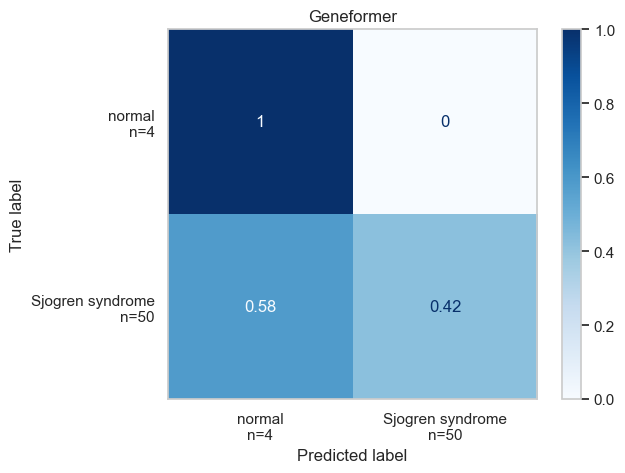

In [35]:
cc.plot_conf_mat(
    conf_mat_dict={"Geneformer": all_metrics["conf_matrix"]},
    output_directory=output_dir,
    output_prefix=output_prefix,
)

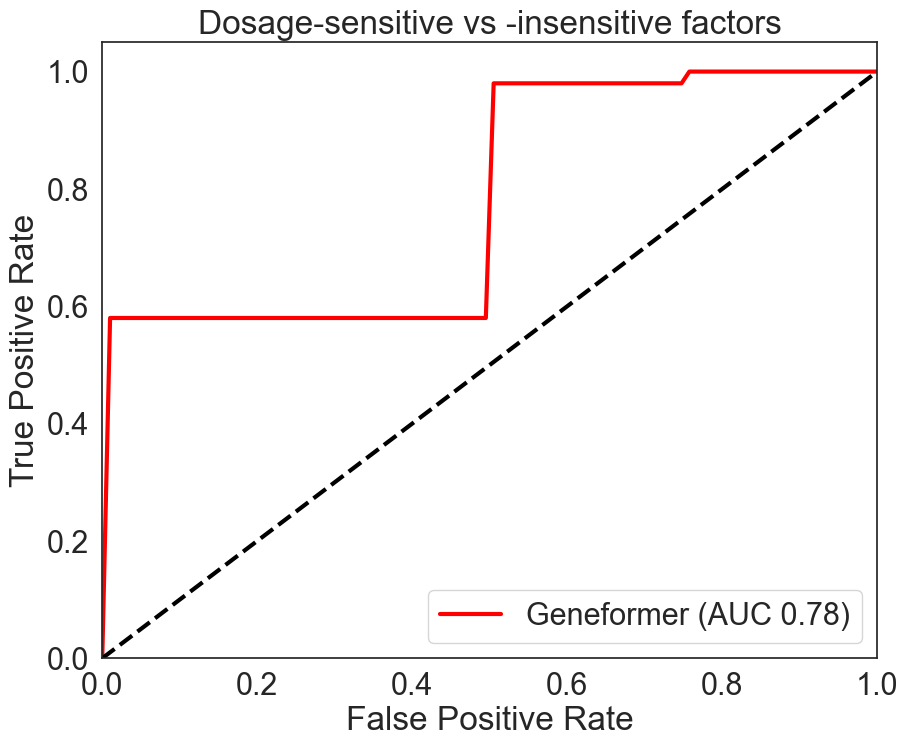

In [36]:
cc.plot_roc(
    roc_metric_dict={"Geneformer": all_metrics["all_roc_metrics"]},
    model_style_dict={"Geneformer": {"color": "red", "linestyle": "-"}},
    title="Dosage-sensitive vs -insensitive factors",
    output_directory=output_dir,
    output_prefix=output_prefix,
)

In [37]:
all_metrics

{'conf_matrix':                   normal  Sjogren syndrome
 normal               4.0               0.0
 Sjogren syndrome    29.0              21.0,
 'macro_f1': [0.40388275599543205],
 'acc': [0.46296296296296297],
 'all_roc_metrics': {'mean_tpr': array([0.  , 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58,
         0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58,
         0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58,
         0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.58,
         0.58, 0.58, 0.58, 0.58, 0.58, 0.58, 0.98, 0.98, 0.98, 0.98, 0.98,
         0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98,
         0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 1.  , 1.  ,
         1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
         1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
         1.  ]),
  'mean_fpr': array([0.        , 0.01010101, 0.02020202, 0.030

# Embedding extraction and visualization

#### Extract embeddings to visualize the fine-tuned embedding space.

#### When extracting embeddings from the pretrained model prior to task-specific fine-tuning, setting emb_layer=-1 will extract embeddings from the second-to-last layer,  capturing more generalizable features than the last layer which is more closely linked to the pretraining objective of masked learning. However, because the fine-tuning learning objective is designed to directly reflect the biological question at hand, for the fine-tuned model, we recommend setting emb_layer=0 to extract embeddings from the final layer, which directly reflects features optimized for classification.

#### For detailed documentation of the various arguments for embedding extraction, please see here: https://geneformer.readthedocs.io/en/latest/geneformer.emb_extractor.html

In [38]:
import os
os.makedirs(f"{PDIR}/content/embs", exist_ok=True)

In [ ]:
from geneformer import EmbExtractor
import os
model_path = os.path.abspath(f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1").rstrip('/')
print('Will use model_path:', model_path)
cfgp = os.path.join(model_path, 'config.json')
if os.path.exists(model_path):
    print('Model dir exists; listing first 50 entries:')
    try:
        print(os.listdir(model_path)[:50])
    except Exception as e:
        print('Could not list MODEL_DIR contents:', e)
    for key in ["config.json", "pytorch_model.bin", "model.safetensors"]:
        print(key, 'exists:', os.path.exists(os.path.join(model_path, key)))
    cfgp = os.path.join(model_path, 'config.json')
    if os.path.exists(cfgp):
        try:
            with open(cfgp, 'r') as _f:
                import json
                cfg_preview = json.load(_f)
            print('config.json preview keys:', list(cfg_preview.keys()))
        except Exception as e:
            print('Could not read config.json:', e)
else:
    print('Model path does not exist:', model_path)
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['TRANSFORMERS_OFFLINE'] = '1'
print('Set HF_HUB_OFFLINE and TRANSFORMERS_OFFLINE to 1')
embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=2,
    filter_data={"cell-type":[
        "Macrophage",
        "Dendritic cell",
        "B cell",
        "Plasma cell",
        "CD4-positive, alpha-beta T cell",
        "CD8-positive, alpha-beta cytotoxic T cell",
        "mature NK T cell",
        "fibroblast",
        "endothelial cell",
        "smooth muscle cell"
    ]},
    max_ncells=37000,
    emb_layer=0,
    emb_label=["disease", "individual"],
    labels_to_plot=["disease", "individual"],
    forward_batch_size=128,
    nproc=8,
    model_version="V1"
    )
try:
    embs = embex.extract_embs(
        model_path,
        f"{PDIR}/content/processed-data/cm_tokenized.dataset",
        f"{PDIR}/content/embs",
        "cm_finetuned_embs",
    )
    print('Embedding extraction completed; sample shape/info:')
    try:
        print(getattr(embs, 'shape', None))
    except Exception:
        pass
except Exception as exc:
    import traceback
    print('Embedding extraction failed with exception:')
    traceback.print_exc()
    print('\n--- Additional MODEL_DIR diagnostics follow ---')
    try:
        print('Model dir:', model_path)
        print('Contents:', os.listdir(model_path))
    except Exception as e:
        print('Could not list model_path contents:', e)
    try:
        if os.path.exists(cfgp):
            with open(cfgp, 'r') as _f:
                import json
                print('config.json:')
                print(json.dumps(json.load(_f), indent=2))
    except Exception as e:
        print('Failed to print config.json:', e)
    raise

model_version selected as V1 so changing emb_mode from 'cls' to 'cell' as V1 models do not have a <cls> token.


Will use model_path: /Users/aumchampaneri/VSCode Projects/complement-receptor-blockade/content/finetuned_models/260214190400/260214_geneformer_cellClassifier_cm_dz_classifier/ksplit1
Model dir exists; listing first 50 entries:
['model.safetensors', 'checkpoint-18', 'config.json', 'cm_dz_classifier_pred_dict.pkl', 'training_args.bin', 'runs']
config.json exists: True
pytorch_model.bin exists: False
model.safetensors exists: True
config.json preview keys: ['architectures', 'attention_probs_dropout_prob', 'classifier_dropout', 'dtype', 'gradient_checkpointing', 'hidden_act', 'hidden_dropout_prob', 'hidden_size', 'initializer_range', 'intermediate_size', 'layer_norm_eps', 'max_position_embeddings', 'model_type', 'num_attention_heads', 'num_hidden_layers', 'pad_token_id', 'position_embedding_type', 'problem_type', 'transformers_version', 'type_vocab_size', 'use_cache', 'vocab_size']
Set HF_HUB_OFFLINE and TRANSFORMERS_OFFLINE to 1


  0%|          | 0/288 [00:00<?, ?it/s]

In [ ]:
embex.plot_embs(embs=embs,
                plot_style="umap",
                output_directory=f"{PDIR}/content/embs",
                output_prefix="emb_umap",
                max_ncells_to_plot=10000)

In [ ]:
embex.plot_embs(embs=embs,
                plot_style="heatmap",
                output_directory=f"{PDIR}/content/embs",
                output_prefix="emb_heatmap",
                max_ncells_to_plot=10000)

# In silico perturbation to induce desired cell states

#### The fine-tuned model is leveraged for in silico perturbation analysis to predict gene perturbations that would induce desired cell state shifts within the embedding space, for example from disease to healthy.

#### In silico perturbation experiments can also be performed to predict the impact of perturbations on other genes, indicating network connections.

#### The in silico perturbation strategy is versatile in terms of the perturbation type (e.g., delete, overexpress), target gene(s) to perturb individually or in combination, cells to test, model to use, and perturbation goal embedding states (e.g., source state, target state, alternate state).

#### For detailed documentation of the various in silico perturbation strategies and related arguments, please see here: https://geneformer.readthedocs.io/en/latest/geneformer.in_silico_perturber.html

In [ ]:
import os
os.makedirs(f"{PDIR}/content/isp", exist_ok=True)

#### Extract embedding positions of goal state for calculating shifts

In [ ]:
from geneformer import EmbExtractor, InSilicoPerturber

# Extract embedding positions of goal state for calculating shifts.
# Using labels that exist in this tokenized dataset (Sjogren data) instead of the cardiomyopathy example.
cell_states_to_model = {
    "state_key": "disease",
    "start_state": "Sjogren syndrome",  # cells to perturb
    "goal_state": "normal",              # desired target state
    "alt_states": []                       # no alternate states for this example
}
embex = EmbExtractor(
    model_type="CellClassifier",
    num_classes=2, # number of classes of fine-tuned model
    # Use the same cell types we used for fine-tuning so filtering matches this dataset
    filter_data={"cell-type":[
        "Macrophage",
        "Dendritic cell",
        "B cell",
        "Plasma cell",
        "CD4-positive, alpha-beta T cell",
        "CD8-positive, alpha-beta cytotoxic T cell",
        "mature NK T cell",
        "fibroblast",
        "endothelial cell",
        "smooth muscle cell"
    ]},
     max_ncells=37000,
     emb_mode="cell",  # V1 models don't have a CLS token; use cell embeddings
     emb_layer=0, # extracts embeddings from last layer
     emb_label=None,  # must be None for get_state_embs
     labels_to_plot=None,
     forward_batch_size=128,
     nproc=1,
     model_version="V1", # default is V2
     summary_stat="exact_mean",  # required for extracting exact state embeddings
)
state_embs_dict = embex.get_state_embs(cell_states_to_model,
    model_directory=f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
    input_data_file=f"{PDIR}/content/processed-data/cm_tokenized.dataset",
    output_directory=f"{PDIR}/content/isp",
    output_prefix=output_prefix
    )

#### Perform in silico perturbation, providing the goal embedding positions in cell_states_to_model.

In [ ]:
perturbation_type = "delete" # or "overexpress"
genes_to_perturb = "all"
'''
genes_to_perturb = [
    # "ENSG00000173376", # C1QA
    # "ENSG00000159259", # C1QB
    # "ENSG00000159261", # C1QC
    # "ENSG00000159403", # C1R
    # "ENSG00000182326", # C1S
    # "ENSG00000166278", # C2
    "ENSG00000125733", # C3
    # "ENSG00000244731", # C4A
    # "ENSG00000242110", # C4B
    # "ENSG00000106804", # C5
    # "ENSG00000039068", # C6
    # "ENSG00000112936", # C7
    # "ENSG00000188513", # C8A
    # "ENSG00000165917", # C8B
    # "ENSG00000130635", # C8G
    # "ENSG00000113600", # C9
    # "ENSG00000243649", # CFB (Factor B)
    # "ENSG00000197409", # CFD (Factor D)
    # "ENSG00000126746", # CFP (Properdin)
    # "ENSG00000165457", # MBL2
    # "ENSG00000127241", # MASP1
    # "ENSG00000114737", # MASP2
    "ENSG00000000971", # CFH (Factor H)
    # "ENSG00000184489", # CFI (Factor I)
    # "ENSG00000149131", # SERPING1 (C1-INH)
    # "ENSG00000117350", # CD46 (MCP)
    # "ENSG00000163504", # CD55 (DAF)
    # "ENSG00000085063", # CD59
    # "ENSG00000123838", # C4BPA
    # "ENSG00000123843", # C4BPB
    # "ENSG00000203710", # CR1
    # "ENSG00000117322", # CR2
    "ENSG00000138382", # C3AR1
    "ENSG00000197405", # C5AR1
    # "ENSG00000067646", # ITGAM (CR3 Alpha)
    # "ENSG00000198081", # ITGAX (CR4 Alpha)
    # "ENSG00000113119", # ITGB2 (CD18)
    # "ENSG00000163914", # CFHR1
    # "ENSG00000134765", # CFHR2
    # "ENSG00000169896", # CFHR3
    # "ENSG00000140678", # CFHR4
    # "ENSG00000160255"  # CFHR5
]
'''


isp = InSilicoPerturber(perturb_type=perturbation_type,
                        genes_to_perturb=genes_to_perturb,
                        model_type="CellClassifier",
                        num_classes=2,
                        emb_mode="cell",
                        filter_data={"cell-type":[
                            "Macrophage",
                            "Dendritic cell",
                            "B cell",
                            "Plasma cell",
                            "CD4-positive, alpha-beta T cell",
                            "CD8-positive, alpha-beta cytotoxic T cell",
                            "mature NK T cell",
                            "fibroblast",
                            "endothelial cell",
                            "smooth muscle cell"
                        ]},
                        cell_states_to_model=cell_states_to_model,
                        state_embs_dict=state_embs_dict,
                        max_ncells=37000,
                        emb_layer=0,
                        forward_batch_size=32,  # REDUCED
                        nproc=1,                # REDUCED
                        model_version="V1"
                        )

In [ ]:
isp.perturb_data(
    model_directory = f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
    input_data_file=f"{PDIR}/content/processed-data/cm_tokenized.dataset",
    output_directory=f"{PDIR}/content/isp",
    output_prefix=output_prefix
)

In [ ]:
import os
os.makedirs(f"{PDIR}/content/results", exist_ok=True)

#### Aggregate data from in silico perturbation experiments and perform statistics.

#### In this case the analysis mode is "goal_state_shift" given the in silico perturbation was set up to predict perturbations that shift cells towards a goal cell state.

#### For detailed documentation of the various in silico perturbation stat modes, related arguments, and description of output column meanings, please see here: https://geneformer.readthedocs.io/en/latest/geneformer.in_silico_perturber_stats.html

In [ ]:
ispstats.get_stats(
    f"{PDIR}/content/isp",
    None,
    f"{PDIR}/content/results",
    "isd_gsshift"
)

#### Load output csv as dataframe to review results

In [ ]:
import pandas as pd
gss_results = pd.read_csv(f"{PDIR}/content/results/isd_gsshift.csv", index_col=0)
gss_results

#### Analysis mode "aggregate_data"

#### This analysis mode gives the magnitude of the change without forcing the cells to shift to only normal or diseased states; enables more complex outcomes.

In [ ]:
ispstats.get_stats(
    f"{PDIR}/content/isp",
    None,
    f"{PDIR}/content/results",
    "isd_aggd"
)

#### Load output csv as dataframe to review results

In [ ]:
import pandas as pd
agg_results = pd.read_csv(f"{PDIR}/content/results/isd_aggd.csv", index_col=0)
agg_results

#### The above in silico perturbation was only performed on 100 cells for the purposes of demonstrating the code. Below, in silico perturbation results from a larger number of cells is downloaded for visualization of results.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

# Filter for genes with significant shifts in both directions
df = full_results[(full_results['Goal_end_FDR'] < 0.05) & (full_results['Alt_end_FDR_hcm'] < 0.05)]

# Further filter for genes shifting towards one state and away from the other
df = df[((df['Shift_to_goal_end'] > 0) & (df['Shift_to_alt_end_hcm'] < 0)) |
        ((df['Shift_to_goal_end'] < 0) & (df['Shift_to_alt_end_hcm'] > 0))]

# Filter for number of cells with that gene expressed
df = df[df["N_Detections"] > 100]

n_top_genes = 15
top_genes = df.loc[df[["Shift_to_goal_end", "Shift_to_alt_end_hcm"]].abs().sum(axis=1).sort_values(ascending=False).index]["Gene_name"].tolist()[:n_top_genes]

# List of genes you want to annotate
genes_to_annotate = top_genes + ["C3", "CFH", "C3AR1"]

# Scatter plot of shift to goal state (NF) vs shift to alternate state (HCM)
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df,
                x='Shift_to_goal_end',
                y='Shift_to_alt_end_hcm',
                color='red',  # Color for significant points with desired shifts
                size='N_Detections',  # Size based on the number of detections
                sizes=(20, 200),  # Adjust marker sizes
                legend='brief')

# Add titles and labels
plt.title('Candidate therapeutic targets whose in silico repression \n in DCM cardiomyocytes shifts towards NF, away from HCM', fontsize=16)
plt.xlabel('Shift to goal state (NF)', fontsize=14)
plt.ylabel('Shift to alternate state (HCM)', fontsize=14)

# Add a reference line where shifts to NF and HCM are equal
plt.axline((0, 0), slope=1, color='gray', linestyle='--')

# Add red dotted lines to mark zero positions on both axes
plt.axhline(0, color='red', linestyle=':', linewidth=1.5)
plt.axvline(0, color='red', linestyle=':', linewidth=1.5)

# # Annotate selected genes
for _, row in df.iterrows():
    if row['Gene_name'] in genes_to_annotate:
        plt.text(row['Shift_to_goal_end'], row['Shift_to_alt_end_hcm'], row['Gene_name'],
                 fontsize=10, color='black', weight='bold')

# Show plot
plt.tight_layout()
plt.show()
